# Convolutional neural network multi-class classification

__Author:__ John Leung

__Content:__ This program is a CNN using the TensorFlow v2 framework. It accepts a train set of labeled data (X_train, Y_train) to train the weights of the network. Then it tests it on a test set (X_test, Y_test). The architecture of of the CNN follows input → Conv → FC → output. The task involved in the default data is to identify whether a (single) hand is gesturing a number (y = 1 to 5). The default image size is 64×64 with 3 channels (RGB).

This program is inspired by and use data source from the course on [Convolutional Neural Network](https://www.coursera.org/learn/convolutional-neural-networks) provided by __deeplearning.ai__ on __Coursera__.

This programming assignment developped by deeplearning.ai (Kian Katanforoosh, Younes Bensouda Mourri, Andrew Ng) uses a pretrained model that can be downloaded at the following link: http://www.vlfeat.org/matconvnet/pretrained/. The pretrained model's parameters are due to the MatConvNet Team. Their software comes with the license replicated below.


---------------------------------------------------------------------
Copyright (c) 2014-16 The MatConvNet Team.
All rights reserved.

Redistribution and use in source and binary forms are permitted
provided that the above copyright notice and this paragraph are
duplicated in all such forms and that any documentation, advertising
materials, and other materials related to such distribution and use
acknowledge that the software was developed by the MatConvNet
Team. The name of the MatConvNet Team may not be used to endorse or
promote products derived from this software without specific prior
written permission.  THIS SOFTWARE IS PROVIDED ``AS IS'' AND WITHOUT
ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, WITHOUT LIMITATION, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
PURPOSE.
---------------------------------------------------------------------

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

In [3]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
#pp.pprint(model)

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A,tf.transpose(A))
    ### END CODE HERE ###
    
    return GA

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [48]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(tf.transpose(a_C, perm=[0,3,1,2]),shape=[m, n_C, n_H*n_W])
    a_G_unrolled = tf.reshape(tf.transpose(a_G, perm=[0,3,1,2]),shape=[m, n_C, n_H*n_W])
    
    # compute the cost with tensorflow (≈1 line)
    J_content =  tf.reduce_sum( tf.square(a_C_unrolled - a_G_unrolled) )/(4*m*n_H*n_W*n_C)
    ### END CODE HERE ###
    
    return J_content

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


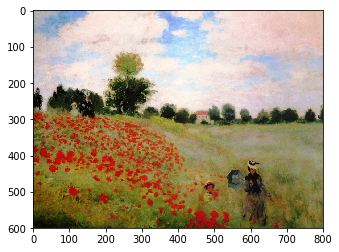

In [6]:
style_image = scipy.misc.imread("images/monet_800600.jpg")
imshow(style_image);

In [10]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A,tf.transpose(A))
    ### END CODE HERE ###
    
    return GA

In [44]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(tf.transpose(a_S, perm=[0,3,1,2]), shape=[n_C, -1])
    a_G = tf.reshape(tf.transpose(a_G, perm=[0,3,1,2]), shape=[n_C, -1])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(GS - GG))/(4*n_H**2*n_W**2*n_C**2)
    
    ### END CODE HERE ###
    
    return J_style_layer

In [45]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [46]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        a_S = model[layer_name]

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [26]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    ### START CODE HERE ### (≈1 line)
    J = alpha*J_content(a_C, a_G) + beta*J_style(model, STYLE_LAYERS)
    ### END CODE HERE ###
    
    return J

/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/opt/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


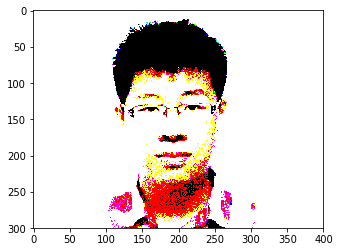

In [27]:
content_image = scipy.misc.imread("images/me.jpg")
content_image = reshape_and_normalize_image(content_image)
style_image = scipy.misc.imread("images/picasso2.jpg")
style_image = reshape_and_normalize_image(style_image)
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

In [28]:
# Assign the content image to be the input of the VGG model.  
model['input'].assign(content_image)

# Select the output tensor of layer conv4_2
a_C = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [29]:
# Assign the input of the model to be the "style" image 
model['input'].assign(style_image)

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [30]:
### START CODE HERE ### (1 line)
J = total_cost(J_content, J_style)
### END CODE HERE ###

In [47]:
# define optimizer (1 line)
optimizer = tf.keras.optimizers.Adam(learning_rate=2.0, beta_1=0.9, beta_2=0.999)

# define train_step (1 line)
running_image = tf.Variable(initial_value=generated_image)
#train_step = optimizer.minimize(total_cost, running_image)

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

TypeError: total_cost() takes at least 2 arguments (0 given)

In [ ]:
def model_nn(sess, input_image, num_iterations = 200):
    
    # Initialize global variables (you need to run the session on the initializer)
    ### START CODE HERE ### (1 line)
    #sess.run(tf.global_variables_initializer())
    ### END CODE HERE ###
    
    # Run the noisy input image (initial generated image) through the model. Use assign().
    ### START CODE HERE ### (1 line)
    model['input'].assign(input_image)
    ### END CODE HERE ###
    
    for i in range(num_iterations):
    
        # Run the session on the train_step to minimize the total cost
        ### START CODE HERE ### (1 line)
        sess.run(train_step)
        ### END CODE HERE ###
        
        # Compute the generated image by running the session on the current model['input']
        ### START CODE HERE ### (1 line)
        generated_image = sess.run(model['input'])
        ### END CODE HERE ###

        # Print every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [ ]:
model_nn(sess, generated_image)